In [1]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler


seed = 7
tf.random.set_seed(seed)

2022-11-27 09:22:16.231728: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 09:22:24.187449: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-27 09:22:36.207787: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-27 09:22:36.208257: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1)
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2)   
    plt.legend()
    plt.show()

In [3]:
def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        
        encoder.fit(x_test)
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    train = pd.read_csv("../data/ML-CUP22-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)
    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    x_test = test.to_numpy().astype(np.float64)
    
    if scale:
        scaler = StandardScaler()
        # scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)
    
    return x_train, y_train, x_test, None
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [75]:
def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged


def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations



def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

            

def get_model(config, input_size, output_size):
    
    lr = config["learning_rate"]
    momentum = config["momentum"]
    init_method = config["initialization"]["type"]
    task = config["task"]
    
    reg_method = config["regularization"]["method"]
    
    if reg_method == "l1":
        reg_value = config["regularization"]["value"]
        reg = lambda: l1(reg_value)
    elif reg_method == "l2":
        reg_value = config["regularization"]["value"]
        reg = lambda: l2(reg_value)
    else:
        reg = lambda: None
    
    
    if init_method == "uniform":
        min_val = config["initialization"]["min"]
        max_val = config["initialization"]["max"]
        
    init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
    optimizer = SGD(learning_rate=lr, momentum=momentum)
    
    n_layers = 0
    for key in config.keys():
        if key.startswith("units_"):
            n_layers += 1

    model = Sequential()
    
    activation = config["activations_1"]
    n_units = config["units_1"]
    model.add(Dense(n_units, input_dim=input_size, activation=activation,
                    kernel_regularizer=reg(), bias_regularizer=reg(),
                    kernel_initializer = init, bias_initializer = init))
    
    for l in range(2,n_layers+1):
        activation = config[f"activations_{l}"]
        n_units = config[f"units_{l}"]
        
        model.add(Dense(n_units, activation=activation,
                        kernel_regularizer=reg(), bias_regularizer=reg(),
                        kernel_initializer = init, bias_initializer = init))
        
        
    if task == "classification":
        model.add(Dense(output_size, activation="sigmoid",
                        kernel_regularizer=reg(), bias_regularizer=reg(),
                        kernel_initializer = init, bias_initializer = init))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
        
    elif task == "regression":
        model.add(Dense(output_size, activation="linear",
                        kernel_regularizer=reg(), bias_regularizer=reg(),
                        kernel_initializer = init, bias_initializer = init))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mse'])
        
    return model
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    early_stopping = config["early_stopping"]
    
    early_stop = EarlyStopping(
        monitor=early_stopping["monitor"], 
        patience=early_stopping["patience"], 
        min_delta=early_stopping["delta"], 
    )
    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for train_index, val_index in kf.split(x_train, y_train):
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
        model = get_model(config, input_size, output_size)
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        history = model.fit(x_train_fold, y_train_fold, epochs=max_epochs,
                            validation_data=(x_val_fold, y_val_fold),
                            callbacks=[early_stop], verbose = 0)
        
        train_loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        
        if task == "classification":
            val_acc = history.history["val_accuracy"]
            train_acc = history.history["accuracy"]
            val_accs.append(val_acc)
            train_accs.append(train_acc)



    mean_train_loss = sum(train_losses[-1])/len(train_losses[-1])
    mean_val_loss = sum(val_losses[-1])/len(val_losses[-1])
    
    if task == "classification":
        mean_train_acc = sum(train_accs[-1])/len(train_accs[-1])
        mean_valid_acc = sum(val_accs[-1])/len(val_accs[-1])

    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    model = get_model(config, input_size, output_size)
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    early_stopping = config["early_stopping"]
    
    early_stop = EarlyStopping(
        monitor=early_stopping["monitor"], 
        patience=early_stopping["patience"], 
    )
    
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True)
    
    history = model.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size,
                        verbose=0, validation_data=(x_val, y_val), callbacks=[early_stop])
        
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    if task == "classification":
        train_acc = history.history["accuracy"]
        val_acc = history.history["val_accuracy"]
    
    return val_loss[-1]
    
    
def fit_model_no_val(x_train, y_train, x_test, y_test, config):
    
    task = config["task"]

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    early_stopping = config["early_stopping"]
    
    if early_stopping["monitor"] == "val_loss":
        early_stopping["monitor"] = "loss"
        
    
    early_stop = EarlyStopping(
        monitor=early_stopping["monitor"], 
        patience=early_stopping["patience"], 
        min_delta=early_stopping["delta"], 
    )
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
        
    model = get_model(config, input_size, output_size)
        
    history = model.fit(x_train, y_train, epochs=max_epochs, validation_data=(x_test, y_test),
                        batch_size=batch_size, verbose=0, callbacks=[early_stop])
    
    if task == "classification":
        train_acc = history.history["accuracy"]
        test_acc = history.history["val_accuracy"]
        plot_curves(train_acc, "Training accuracy", test_acc, "Test accuracy")
    
    train_loss = history.history["loss"]
    test_loss = history.history["val_loss"]
    plot_curves(train_loss, "Train loss", test_loss, "Test loss")
    
    
    return model



    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    input_size = x_test.shape[1]
    result = model.evaluate(x_test, y_test)
    print(result)

    
    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    with tqdm(total=len(configurations)) as pbar:
        for config in configurations:
            print(config)
            val_loss = fit_model(x_train, y_train, config, validation)
            
            if val_loss < best_loss:
                best_loss = val_loss;
                best_conf = config
            
            print(val_loss)
            pbar.update(1)
            
    print("\n\n")
    print(best_conf)
    print(best_loss)
    
    return best_conf
    

def grid_search(params, x_train, y_train, x_test, y_test, validation={"type": "hold-out", "val_split": 0.2}):
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_model_no_val(x_train, y_train, x_test, y_test, best_conf)
    
    return model

In [84]:
params = {
    "task": "classification",
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [None],
    "momentum": [0.9],
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [5],
        },
    ]
}


"""params = {
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": 500,
    "learning_rate": [0.001, 0.01, 0.1],
    "batch_size": [None],
    "momentum": [0.1, 0.9],
    "regularization": [
        {
            "type": "l1",
            "value": [0.0001, 0.001]
        },
        {
            "type": "l2",
            "value": [0.0001, 0.001]
        },
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [1,4,8],
        },
    ]
}"""

k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

# Monks 1

In [85]:
x_train, y_train, x_test, y_test = load_dataset("monks1", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-1 dataset
(124, 17) (124,)
(432, 17) (432,)


  0%|                                                     | 0/1 [00:00<?, ?it/s]

{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.19s/it]

0.22205783484073785



{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}
0.22205783484073785


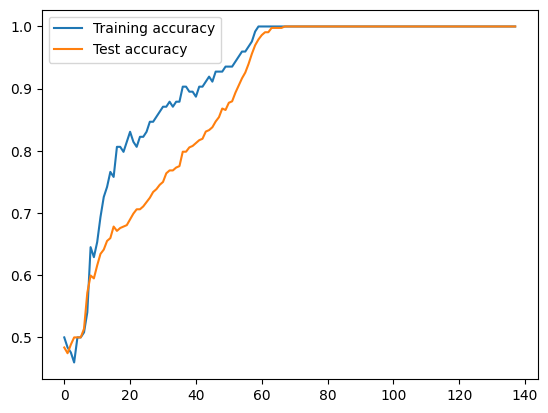

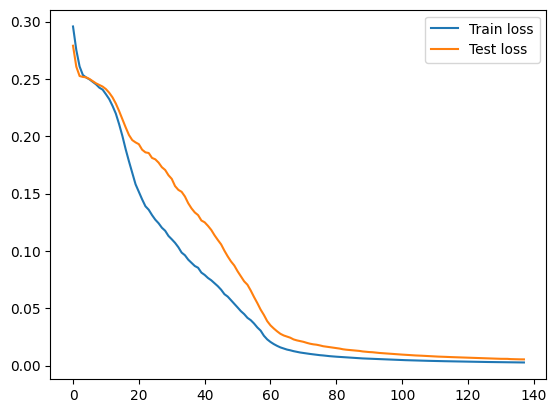

14/14 [==============================] - 0s 2ms/step - loss: 0.0054 - accuracy: 1.0000
[0.005384121090173721, 1.0]


In [86]:
model = grid_search(params, x_train, y_train, x_test, y_test, k_fold_val)
test_model(model, x_test, y_test)

# Monks 2

In [13]:
x_train, y_train, x_test, y_test = load_dataset("monks2", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-2 dataset
(169, 17) (169,)
(432, 17) (432,)


  0%|                                                     | 0/1 [00:00<?, ?it/s]

{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'regularizer': 0.0001, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'activations_1': 'relu', 'units_1': 5}


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.05s/it]

0.0885975039995241



{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'regularizer': 0.0001, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'activations_1': 'relu', 'units_1': 5}
0.0885975039995241


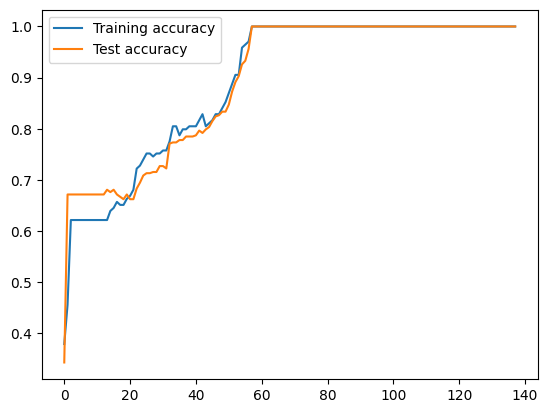

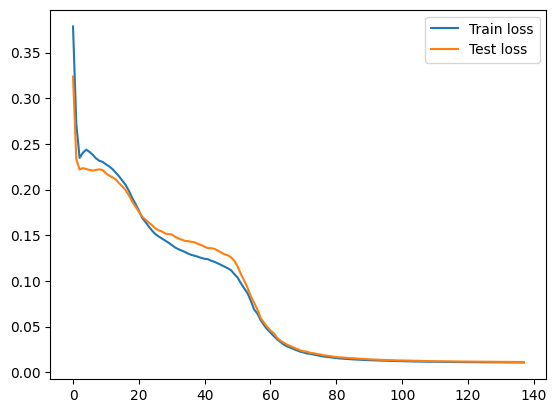

14/14 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 1.0000
[0.011148320510983467, 1.0]


In [14]:
model = grid_search(params, x_train, y_train, x_test, y_test, k_fold_val)
test_model(model, x_test, y_test)

# Monks 3

In [15]:
x_train, y_train, x_test, y_test = load_dataset("monks3", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-3 dataset
(122, 17) (122,)
(432, 17) (432,)


  0%|                                                     | 0/1 [00:00<?, ?it/s]

{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'regularizer': None, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'activations_1': 'relu', 'units_1': 5}


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.76s/it]

0.23260994602081386



{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'regularizer': None, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'activations_1': 'relu', 'units_1': 5}
0.23260994602081386


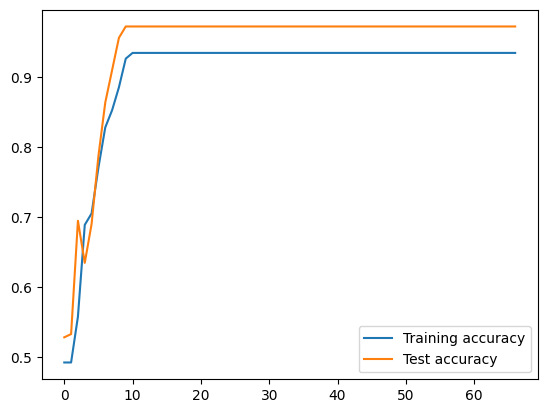

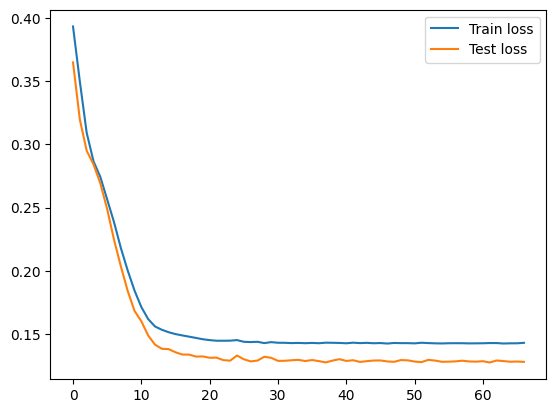

14/14 [==============================] - 0s 2ms/step - loss: 0.1280 - accuracy: 0.9722
[0.12798188626766205, 0.9722222089767456]


In [20]:
model = grid_search(params, x_train, y_train, x_test, y_test, k_fold_val)
test_model(model, x_test, y_test)

# ML Cup

In [17]:
x_train, y_train, x_test, _ = load_dataset("cup", True)
print(x_train.shape, y_train.shape)
print(x_test.shape)

(1492, 9) (1492, 2)
(529, 9)


In [22]:
params = {
    "task": "regression",
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 100,
        "delta": 0.000
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [32],
    "momentum": [0.1],
    "regularization": [
        None
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
        {
            "activations": ["relu"],
            "units": [],
        }
    ]
}


"""params = {
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": 500,
    "learning_rate": [0.001, 0.01, 0.1],
    "batch_size": [None],
    "momentum": [0.1, 0.9],
    "regularizer": [0, 0.1],
    "layers": [
        {
            "activations": ["relu"],
            "units": [1,4,8],
        },
    ]
}"""

k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

  0%|                                                     | 0/1 [00:00<?, ?it/s]

{'batch_size': 32, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'regularizer': 0, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 100, 'delta': 0.0}, 'task': 'regression', 'activations_1': 'relu', 'units_1': 8}


100%|█████████████████████████████████████████████| 1/1 [00:35<00:00, 35.41s/it]

0.005321248900145292



{'batch_size': 32, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.1, 'regularizer': 0, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 100, 'delta': 0.0}, 'task': 'regression', 'activations_1': 'relu', 'units_1': 8}
0.005321248900145292


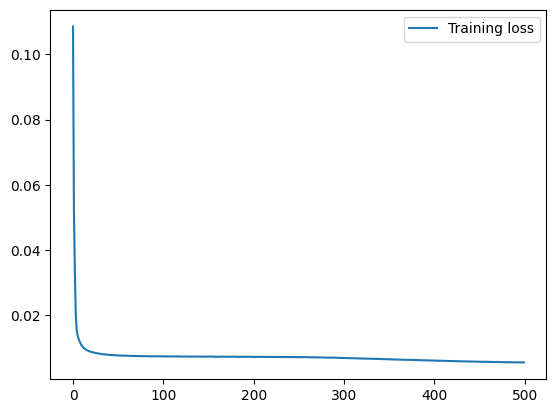

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 8)                 80        
                                                                 
 dense_18 (Dense)            (None, 2)                 18        
                                                                 
Total params: 98
Trainable params: 98
Non-trainable params: 0
_________________________________________________________________


In [23]:
model = grid_search(params, x_train, y_train, x_test, y_test, hold_out_val)
model.summary()
# test_model(model, x_test, y_test)

(2,)
[[0.88921196 0.3676885 ]
 [0.74337106 0.29578539]
 [0.11856858 0.82513027]
 ...
 [0.39385832 0.18203218]
 [0.10539795 0.58269516]
 [0.72450877 0.29270614]]


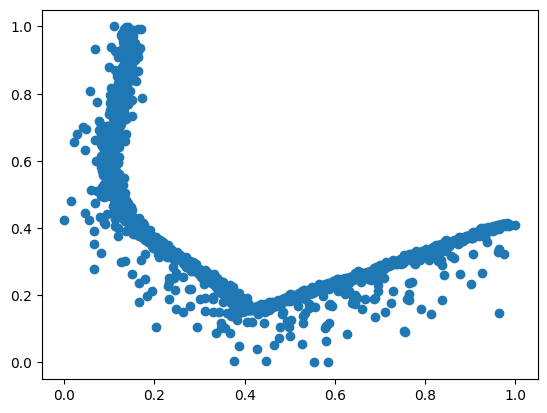

In [26]:
print(y_train[0].shape)
plt.scatter(y_train[:, 0], y_train[:, 1])
print(y_train)

47/47 [==============================] - 0s 1ms/step


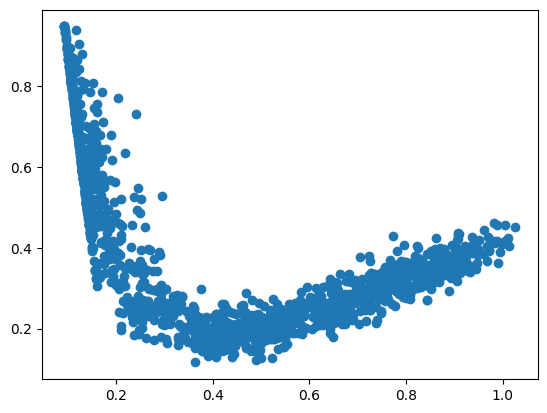

In [27]:
pred = model.predict(x_train)
plt.scatter(pred[:, 0], pred[:, 1])